In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

# import plotting stuff
from utils.plot_utils import *

# import data loading stuff
from utils.data_utils import load_movement_df

In [3]:
path_to_data = os.path.join('..', '..', 'data')
movement_df, ward2cluster = load_movement_df(path_to_data, True)

wrd_size_df = movement_df.reset_index()
wrd_size_df["num_patients"] = 1
wrd_size_df = wrd_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
wrd_size_df = wrd_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
wrd_size_df.tail( 20 )


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_20098/3268673969.py:2: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True)


,ward,ward_id,num_patients
216,Presbyterian Hospital-Vc 3 Pft Main Lab,27,19.419492
211,Presbyterian Hospital-Pby 4 Transplant Infusio...,206,21.033898
197,Mschony-Msch Operating Room,55,21.464286
78,Herbert Irving Pavilion-Hip 7 Col Ped Hem Onc Bmt,46,22.929504
23,Allen Hospital-Aln 1 River West,12,22.997238
144,Milstein Hospital-Mil Cardiac Cath,38,23.965147
176,Mschony-Msch 10 Trans Nursery,59,26.951531
103,Milstein Hospital-Aln Emergency,64,28.806701
209,Presbyterian Hospital-Pby 14 Transplant Infusi...,21,46.305970
83,Milstein Family Heart Ctr-Hrt 4 Col Proc Card Med,19,58.273616


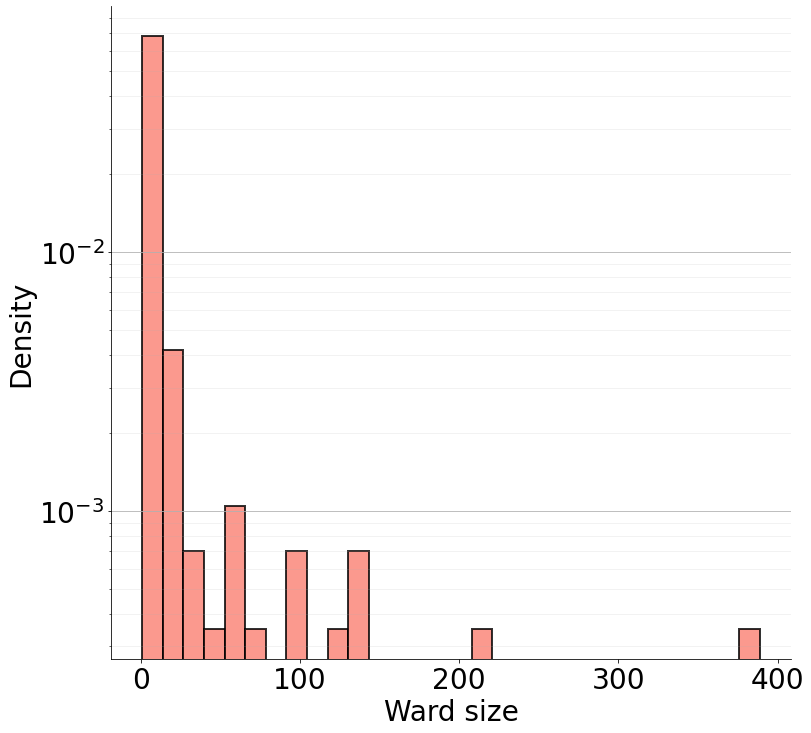

In [4]:
# WARD SIZE DISTRIBUTION
ward_size_df = movement_df.reset_index()
ward_size_df["num_patients"]= 1
ward_size_df = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df = ward_size_df.groupby("ward_id").mean().reset_index()

ward2size    = {r.ward_id: r.num_patients for idx, r in ward_size_df.iterrows()}

fig_dims = figure_size_setting(1100); fig_dims = [fig_dims[0], 12*1]
fig, ax = plt.subplots(1, 1, figsize=fig_dims)

ax.hist(ward_size_df[ward_size_df.num_patients>0].num_patients, bins=30, edgecolor="k", lw=2, facecolor="salmon", alpha=0.8, density=True, align="mid")
ax.set_yscale('log')
ax.set_xlabel("Ward size")
ax.set_ylabel("Density")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis="y")
ax.grid(axis="y", which="minor", alpha=0.2)

#path_to_save  = os.path.join(path_to_ms_figs, "ward_occupancy_dist.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


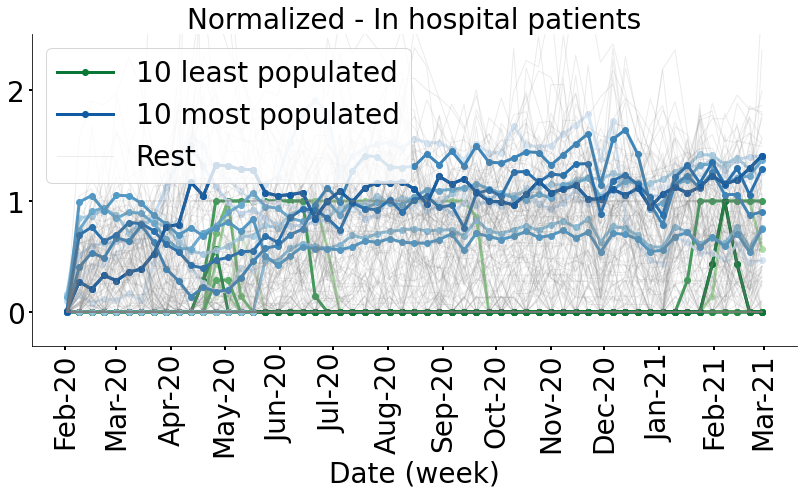

In [5]:
from utils.plot_utils import format_axis
import seaborn as sns

admissions_df = movement_df.copy().reset_index(); admissions_df = admissions_df[admissions_df.first_day==1].rename(columns={"first_day": "num_admissions"})
admissions_df = admissions_df.groupby(["ward_id", "date"]).sum()[["num_admissions"]]#.unstack([0]).sum().stack().reset_index()
admissions_df = admissions_df.reset_index()

admissions_df["day_of_week"] = admissions_df.date.dt.dayofweek
ward_size_df                 = movement_df.copy().reset_index()
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].unstack([-1]).resample("1D").sum().stack().reset_index()

ward_size_df["date_map"] = ward_size_df["date"].map(lambda x: x.strftime('%d-%b'))
wards                    = ward_size_df.ward_id.unique()

fig_dims = figure_size_setting(1100)
fig, ax = plt.subplots(1, 1, figsize=fig_dims)


df_size = pd.DataFrame.from_dict(ward2size, orient="index").reset_index().sort_values(by=0).iloc[::-1]
wards = df_size.index.values

top_consider = 10

colors = sns.color_palette("Greens", n_colors=top_consider+1, desat=True)
for w_idx, w_id in enumerate(wards[len(wards)-top_consider:]):
    w_df = ward_size_df[ward_size_df.ward_id==w_id]
    w_df = w_df.groupby(["date", "ward_id"]).sum().unstack(-1).resample("W-Sun").sum()[["num_patients"]].reset_index()
    ax.plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o")
ax.plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o", label="10 least populated")

colors = sns.color_palette("Blues", n_colors=top_consider+1, desat=True)
for w_idx, w_id in enumerate(wards[:top_consider]):
    w_df = ward_size_df[ward_size_df.ward_id==w_id]
    w_df = w_df.groupby(["date", "ward_id"]).sum().unstack(-1).resample("W-Sun").sum()[["num_patients"]].reset_index()
    ax.plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o")
ax.plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o", label="10 most populated")

for w_idx, w_id in enumerate(wards[:]):
    w_df = ward_size_df[ward_size_df.ward_id==w_id]
    w_df = w_df.groupby(["date", "ward_id"]).sum().unstack(-1).resample("W-Sun").sum()[["num_patients"]].reset_index()
    if w_idx<=top_consider and w_idx <= len(wards)-w_idx:
        continue
        #ax.plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o")
    else:
        ax.plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color="gray", lw=1, alpha=0.15)
ax.plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color="gray", lw=1, alpha=0.15, label="Rest")


ylimmm = ax.get_ylim()
ax.legend(loc="upper left")
ax.set_ylim([ylimmm[0], 2.5])
ax.set_xlabel("Date (week)"); ax.set_title("Normalized - In hospital patients")
format_axis(ax, week=False)
plt.tight_layout()

ax.tick_params(width=2)
#path_to_save  = os.path.join(path_to_ms_figs, "in_hospital_patients_per_ward_size.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


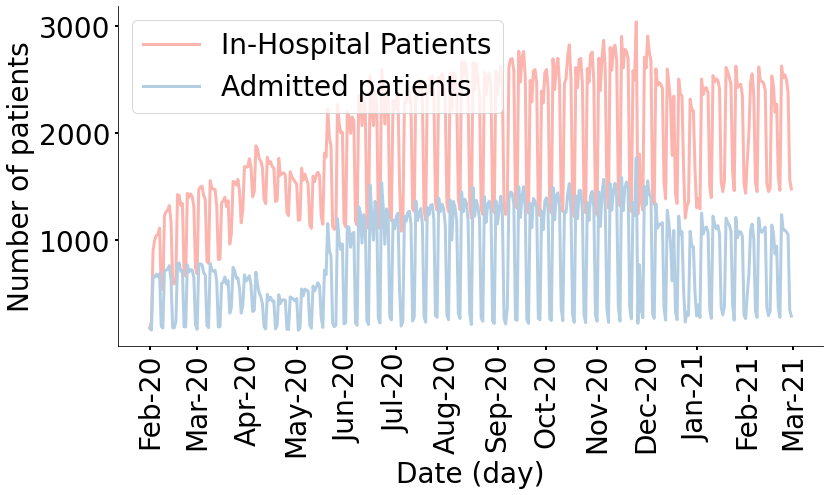

In [6]:
colors = sns.color_palette("Pastel1", n_colors=2)

w_all_df = ward_size_df.groupby("date").sum().reset_index()
fig, ax = plt.subplots(1, 1, figsize=fig_dims)
ax.plot(w_all_df.date, w_all_df.num_patients, label="In-Hospital Patients", color=colors[0], lw=3)
admision_weekly_plot_df = admissions_df.groupby(["date"]).sum()[["num_admissions"]].resample("1D").sum().reset_index()
ax.plot(admision_weekly_plot_df.date, admision_weekly_plot_df.num_admissions, label="Admitted patients", color=colors[1], lw=3)
format_axis(ax, week=False)
ax.set_xlabel("Date (day)"); ax.set_ylabel("Number of patients")
ax.legend(loc="upper left")
ax.tick_params(width=2)

plt.tight_layout()

#path_to_save  = os.path.join(path_to_ms_figs, "admission_in_hospital_patients.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


In [7]:
date_format_display = '%d-%b-%y'

# testing per week
testing_per_ward_df = movement_df.copy(); testing_per_ward_df = testing_per_ward_df[testing_per_ward_df.test==1].reset_index()
testing_per_ward_df = testing_per_ward_df.groupby(["date", "ward_id"]).sum().unstack(1).resample("W-Sun").sum().stack().reset_index()[["ward_id", "date", "test"]]

date_order = testing_per_ward_df["date"].unique()

testing_per_ward_df["date_map"] = testing_per_ward_df["date"].map(lambda x: x.strftime(date_format_display))
testing_mat_per_ward_df         = testing_per_ward_df.pivot(index="ward_id", columns=["date_map"], values="test").fillna(0)

date_order = pd.DataFrame(date_order)[0].map(lambda x: x.strftime(date_format_display)).values
testing_mat_per_ward_df = testing_mat_per_ward_df[date_order]

# admissions per week
admissions_per_ward_df = movement_df.copy().reset_index().groupby(["date", "ward_id"]).sum().reset_index()
admissions_per_ward_df = admissions_per_ward_df.set_index(["date", "ward_id"]).unstack(1).resample("W-Sun").sum().stack().reset_index()
ward_test_df           = admissions_per_ward_df.reset_index().groupby("ward_id").sum().reset_index().sort_values(by="first_day")
ward_order             = np.flip(ward_test_df["ward_id"].values)

admissions_per_ward_df["date_map"] = admissions_per_ward_df["date"].map(lambda x: x.strftime(date_format_display))
admissions_mat_per_ward_df         = admissions_per_ward_df.pivot(index="ward_id", columns=["date_map"], values="first_day").fillna(0)

date_order = admissions_per_ward_df["date"].unique()
date_order = pd.DataFrame(date_order)[0].map(lambda x: x.strftime(date_format_display)).values

admissions_mat_per_ward_df = admissions_mat_per_ward_df[date_order]


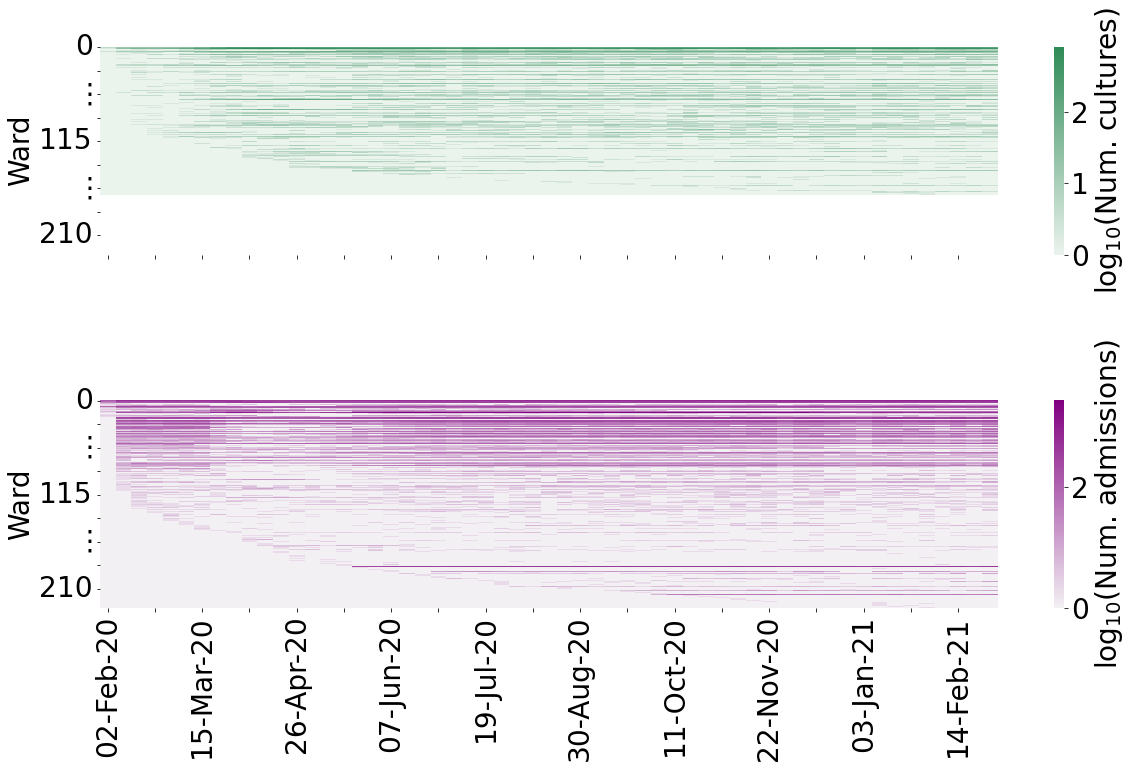

In [8]:

xx_ticks =['02-Feb-20', '', '15-Mar-20', '', '26-Apr-20', '', '07-Jun-20', '', '19-Jul-20', '', '30-Aug-20', '', '11-Oct-20', '', '22-Nov-20', '', '03-Jan-21', '', '14-Feb-21']

fig_dims = figure_size_setting(1600)

fig, ax = plt.subplots(2, 1, figsize=fig_dims, sharex=True, sharey=True)
g = sns.heatmap(ax=ax[0], data=np.log10(testing_mat_per_ward_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(Num. cultures)"})
ax[0].set_xlabel(None)

g.set(yticklabels=['0','', r'$\vdots$','','115','',r'$\vdots$','','210'])
g.set(xticklabels=xx_ticks)

g = sns.heatmap(ax=ax[1], data=np.log10(admissions_mat_per_ward_df+1), cmap=sns.light_palette("purple", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(Num. admissions)"})
#ax[1].set_xlabel("Date (weekly)")
ax[0].set_ylabel("Ward")
ax[1].set_ylabel("Ward")
ax[1].set_xlabel(None)

#g.set(yticklabels=['0','','', r'$\vdots$','','','115','',r'$\vdots$','','','210'])
g.set(yticklabels=['0','', r'$\vdots$','','115','',r'$\vdots$','','210'])
g.set(xticklabels=xx_ticks)

plt.tight_layout()
plt.subplots_adjust(hspace=0.7)

#path_to_save  = os.path.join(path_to_ms_figs, "heatmaps_test_admission.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


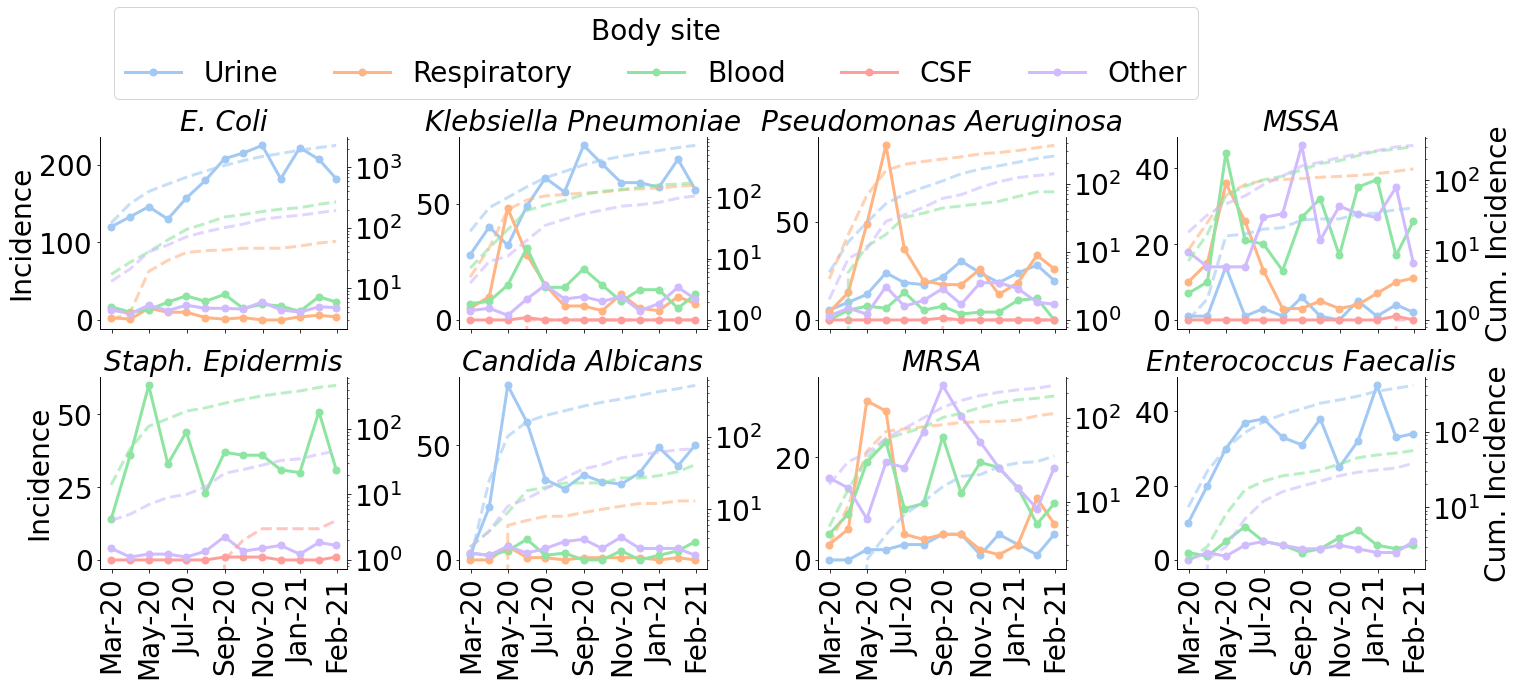

In [9]:
specimens_inference = ["ESCHERICHIA COLI", "KLEBSIELLA PNEUMONIAE", "PSEUDOMONAS AERUGINOSA", "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS",
                        "STAPHYLOCOCCUS EPIDERMIDIS", "CANDIDA ALBICANS", "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS", "ENTEROCOCCUS FAECALIS"]
sites               = ['Urine', 'Respiratory', 'Blood', 'CSF', 'Other',]

pathogen_time_df = movement_df.copy().reset_index().groupby(["date", "organism_name",  "specimen_group"]).sum()[["test"]].unstack([1, 2]).resample("M").sum().stack().stack().reset_index()
pathogen_time_df = pathogen_time_df[pathogen_time_df.organism_name.isin(specimens_inference)]


fig_dims = figure_size_setting(1500)
fig_dims = [fig_dims[0], fig_dims[1]*1]

fig, axes = plt.subplots(2, 4, figsize=(23, 12), sharex=True)
idx = 0

#fig.delaxes(axes[-1, -1])

colors = sns.color_palette("pastel") #"ch:start=.2,rot=-1.1", n_colors=len(sites))

axes_t = []
for specimen in specimens_inference:
    ax      = axes.flatten()[idx]
    ax_t    = ax.twinx()

    ax.spines['top'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    axes_t.append(ax_t)
    format_axis(ax, week=False)

    sp_title = specimen
    if specimen == "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        sp_title = "MSSA"
    elif specimen == "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        sp_title = "MRSA"
    elif specimen == "STAPHYLOCOCCUS EPIDERMIDIS":
        sp_title = "Staph. Epidermis"
    elif sp_title == "ESCHERICHIA COLI":
        sp_title = "E. Coli"
    else:
        sp_title = " ".join([w.capitalize() for w in sp_title.lower().split(" ")])

    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.set_title(sp_title, fontstyle="italic")

    for idx_site, site in enumerate(sites):
        path_df = pathogen_time_df[pathogen_time_df.organism_name==specimen]
        path_df = path_df[path_df.specimen_group==site]

        ax_t.plot(path_df["date"], path_df["test"].cumsum(), linestyle="--", lw=3, alpha=0.6, label=site, c=colors[idx_site])
        ax.plot(path_df["date"], path_df["test"], marker='o', lw=3, c=colors[idx_site], ms=7, label=site)
        ax_t.set_yscale("log")
    idx += 1

axes_t[3].set_ylabel("Cum. Incidence")
#axes_t[5].set_ylabel("Cum. Incidence", fontsize=18)
axes_t[7].set_ylabel("Cum. Incidence")

#axes[-1,0].set_xlabel("Date (month)")
#axes[-1,1].set_xlabel("Date (month)")
#axes[1,-1].set_xlabel("Date (month)")

axes[0,0].set_ylabel(r"Incidence")
axes[1,0].set_ylabel(r"Incidence")
#axes[2,0].set_ylabel(r"Incidence", fontsize=18)

x_ticks_pos    = [18322.0,  18353.0, 18383.0, 18414.0, 18444.0, 18475.0, 18506.0, 18536.0, 18567.0, 18597.0, 18628.0, 18659.0, 18687.0, 18718.0]
x_ticks_labels = ['Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21']

x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]

axes[1,0].set_xticks(x_ticks_pos, x_ticks_labels)
#axes[1,1]

axes[0,0].legend(loc="upper left", title="Body site", bbox_to_anchor=(0.0, 1.75), ncol=5)

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.6, wspace=0.45, hspace=0.25)

#plt.tight_layout()
#path_to_save  = os.path.join(path_to_ms_figs, "incident_observations_AMROs.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


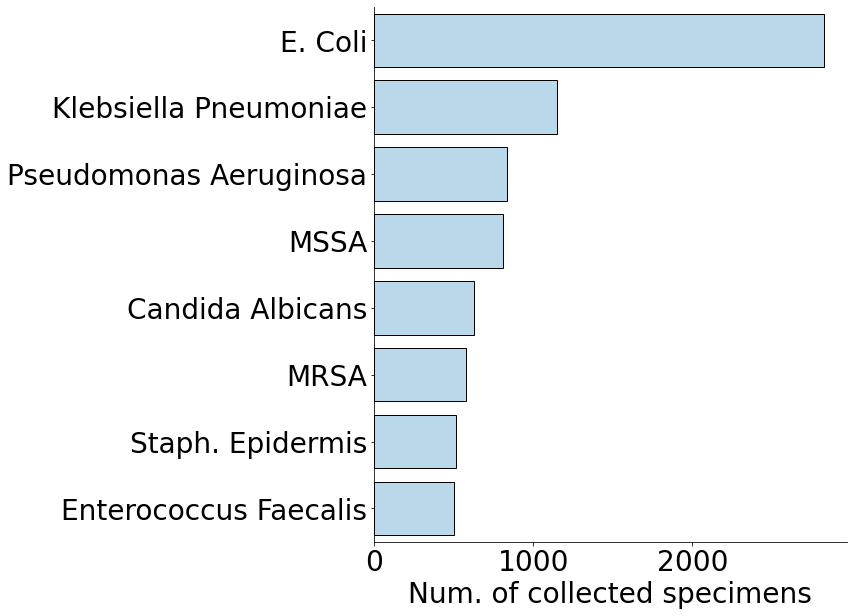

In [10]:
def specimen2title(specimen):
    sp_title = specimen
    if specimen == "METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS":
        sp_title = "MSSA"
    elif specimen == "METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS":
        sp_title = "MRSA"
    elif specimen == "STAPHYLOCOCCUS EPIDERMIDIS":
        sp_title = "Staph. Epidermis"
    elif sp_title == "ESCHERICHIA COLI":
        sp_title = "E. Coli"
    else:
        sp_title = " ".join([w.capitalize() for w in sp_title.lower().split(" ")])
    return sp_title


bar_ppt_df                  = pathogen_time_df.groupby("organism_name").sum().reset_index().sort_values(by="test").iloc[::-1]
bar_ppt_df["organism_name"] = bar_ppt_df["organism_name"].map(lambda x: specimen2title(x))


fig, ax = plt.subplots(1, 1, figsize=(12.5, 9.2))
sns.barplot(ax=ax, data=bar_ppt_df, x="test", y="organism_name", facecolor="#B9D9EB", edgecolor="k")
ax.set_xlabel("Num. of collected specimens")
ax.set_ylabel(None)
sns.despine(top=True, right=True)
plt.tight_layout()

path_to_save  = os.path.join(".", "AMRO_barplot.png")
fig.savefig(path_to_save, dpi=300, transparent=True)


# Figure 2 - Revision

In [13]:
paper_dir

'/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals/papers'

In [11]:
paper_dir             = config.get_property('paper_dir')


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_20098/1076201281.py:48: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.6, wspace=0.45, hspace=0.25)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_20098/1076201281.py:101: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


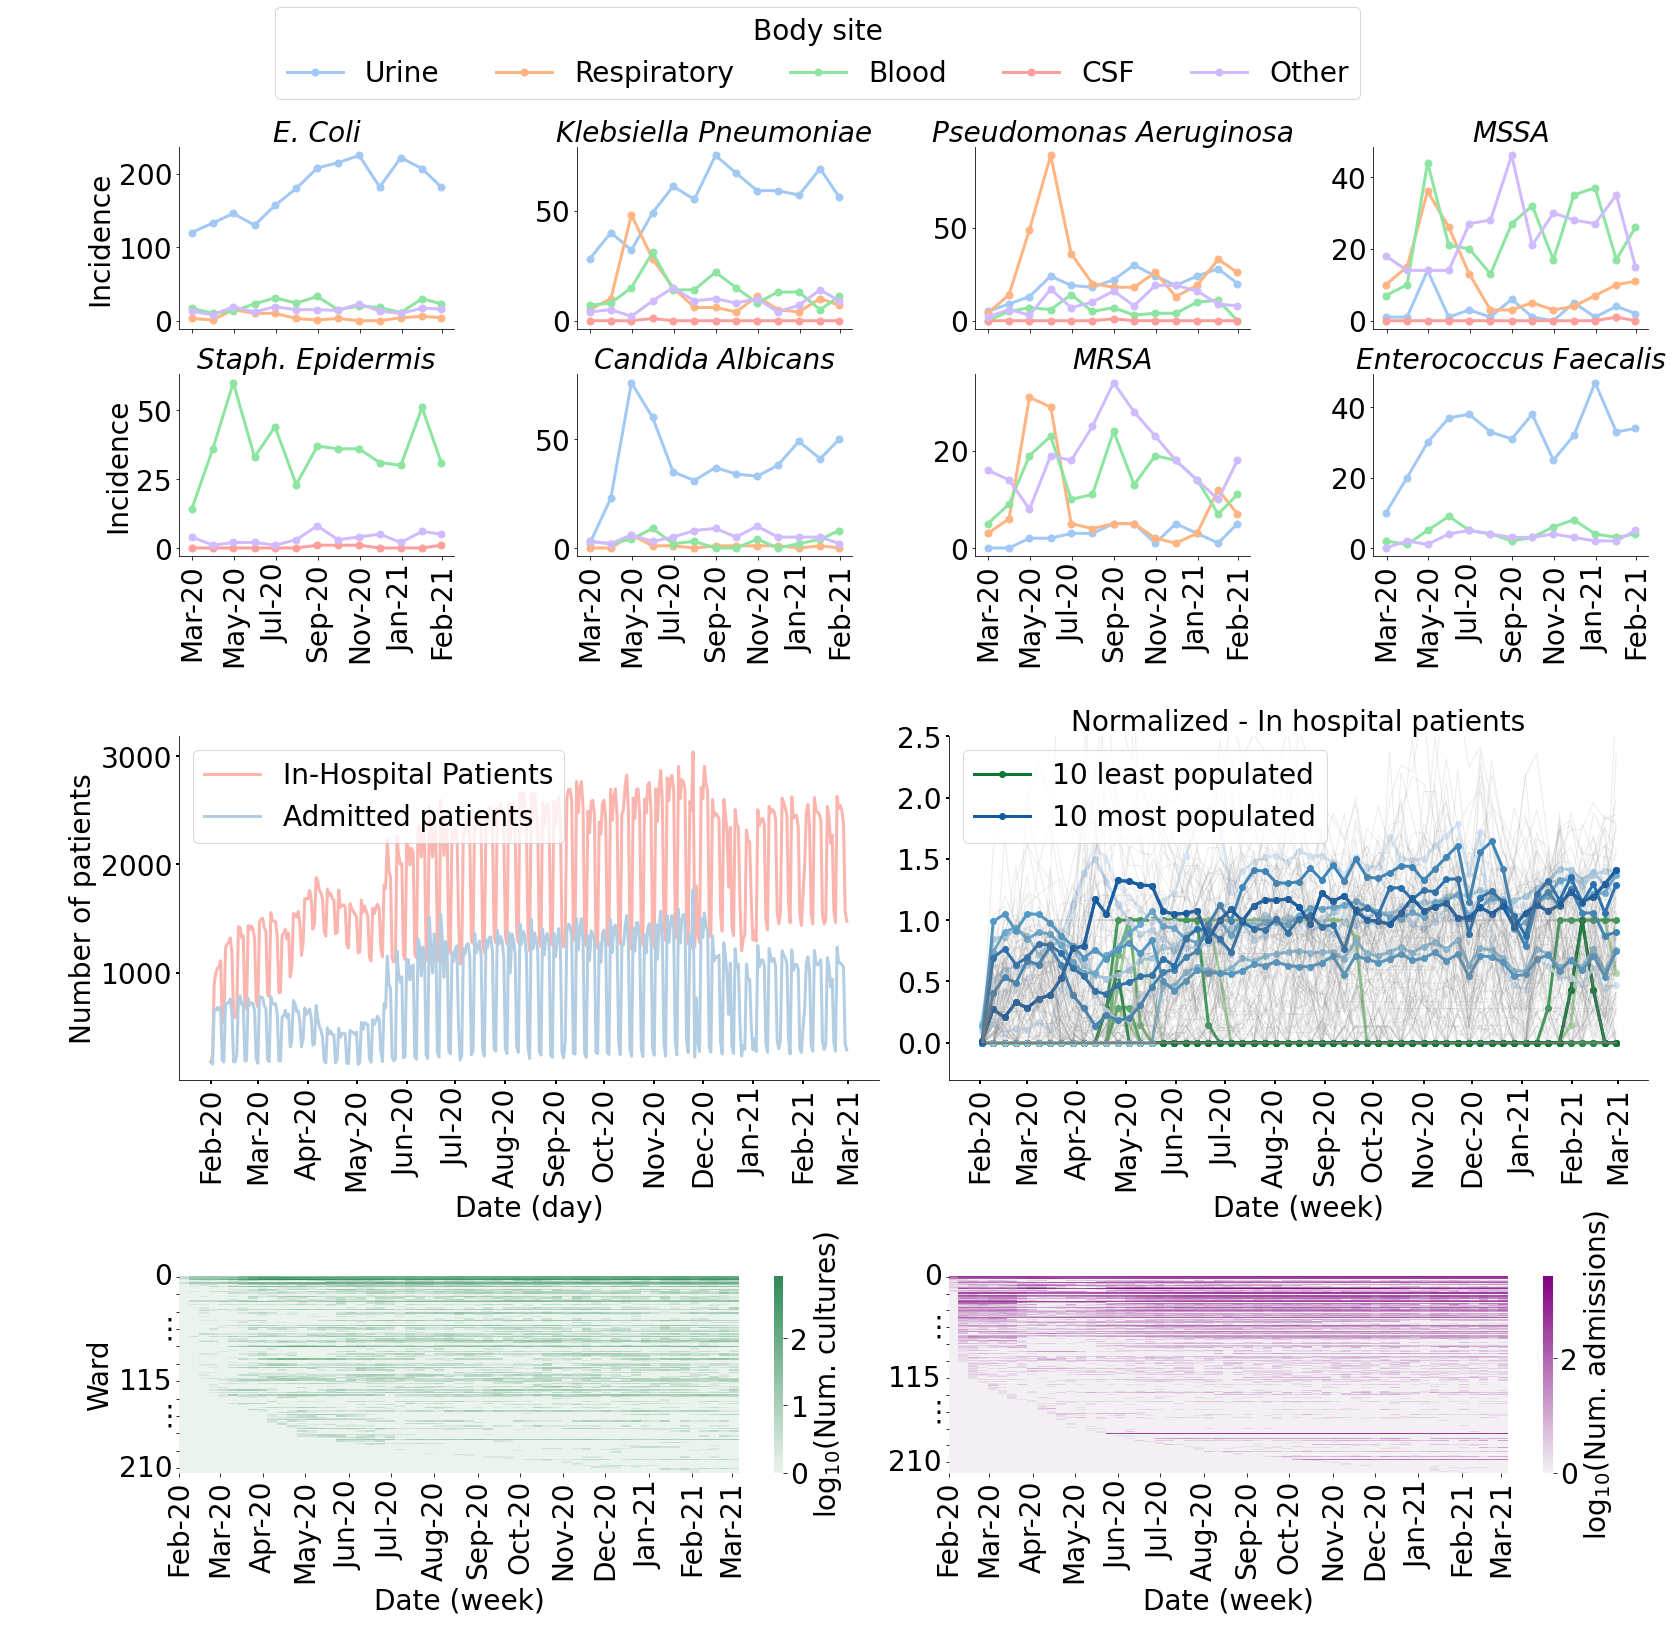

In [14]:
from utils.plot_utils import format_axis
import seaborn as sns

admissions_df = movement_df.copy().reset_index(); admissions_df = admissions_df[admissions_df.first_day==1].rename(columns={"first_day": "num_admissions"})
admissions_df = admissions_df.groupby(["ward_id", "date"]).sum()[["num_admissions"]]#.unstack([0]).sum().stack().reset_index()
admissions_df = admissions_df.reset_index()

admissions_df["day_of_week"] = admissions_df.date.dt.dayofweek
ward_size_df                 = movement_df.copy().reset_index()
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].unstack([-1]).resample("1D").sum().stack().reset_index()

ward_size_df["date_map"] = ward_size_df["date"].map(lambda x: x.strftime('%d-%b'))
wards                    = ward_size_df.ward_id.unique()


################################ Part 2 ################################

fig     = plt.figure(constrained_layout=True, figsize=(24, 25))
subfigs = fig.subfigures(3, 1, hspace=0.07, wspace=0.01, height_ratios=[0.5, 0.3, 0.3])

axes    = subfigs[0].subplots(2, 4, sharex=True)
idx     = 0
colors = sns.color_palette("pastel") #"ch:start=.2,rot=-1.1", n_colors=len(sites))
for specimen in specimens_inference:
    ax      = axes.flatten()[idx]
    ax.spines['top'].set_visible(False)
    format_axis(ax, week=False)

    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.set_title(specimen2title(specimen), fontstyle="italic")

    for idx_site, site in enumerate(sites):
        path_df = pathogen_time_df[pathogen_time_df.organism_name==specimen]
        path_df = path_df[path_df.specimen_group==site]
        ax.plot(path_df["date"], path_df["test"], marker='o', lw=3, c=colors[idx_site], ms=7, label=site)
    idx += 1
axes[0,0].set_ylabel(r"Incidence")
axes[1,0].set_ylabel(r"Incidence")
x_ticks_pos    = [18322.0,  18353.0, 18383.0, 18414.0, 18444.0, 18475.0, 18506.0, 18536.0, 18567.0, 18597.0, 18628.0, 18659.0, 18687.0, 18718.0]
x_ticks_labels = ['Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21', 'Apr-21']
x_ticks_pos    = [18322.0,  18383.0,   18444.0,   18506.0,    18567.0,  18628.0,  18687.0]
x_ticks_labels = ['Mar-20',  'May-20',  'Jul-20',  'Sep-20',  'Nov-20',  'Jan-21', 'Feb-21' ]

axes[1,0].set_xticks(x_ticks_pos, x_ticks_labels)
axes[0,0].legend(loc="upper left", title="Body site", bbox_to_anchor=(0.3, 1.85), ncol=5)

fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.6, wspace=0.45, hspace=0.25)



################################ Part 2 ################################
colors = sns.color_palette("Pastel1", n_colors=2)
axes3    = subfigs[1].subplots(1, 2, sharex=True)
w_all_df = ward_size_df.groupby("date").sum().reset_index()
axes3[0].plot(w_all_df.date, w_all_df.num_patients, label="In-Hospital Patients", color=colors[0], lw=3)
admision_weekly_plot_df = admissions_df.groupby(["date"]).sum()[["num_admissions"]].resample("1D").sum().reset_index()
axes3[0].plot(admision_weekly_plot_df.date, admision_weekly_plot_df.num_admissions, label="Admitted patients", color=colors[1], lw=3)
format_axis(axes3[0], week=False)
axes3[0].set_xlabel("Date (day)"); axes3[0].set_ylabel("Number of patients")
axes3[0].legend(loc="upper left")
axes3[0].tick_params(width=2)



df_size = pd.DataFrame.from_dict(ward2size, orient="index").reset_index().sort_values(by=0).iloc[::-1]
wards = df_size.index.values

top_consider = 10

colors = sns.color_palette("Greens", n_colors=top_consider+1, desat=True)
for w_idx, w_id in enumerate(wards[len(wards)-top_consider:]):
    w_df = ward_size_df[ward_size_df.ward_id==w_id]
    w_df = w_df.groupby(["date", "ward_id"]).sum().unstack(-1).resample("W-Sun").sum()[["num_patients"]].reset_index()
    axes3[1].plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o")
axes3[1].plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o", label="10 least populated")

colors = sns.color_palette("Blues", n_colors=top_consider+1, desat=True)
for w_idx, w_id in enumerate(wards[:top_consider]):
    w_df = ward_size_df[ward_size_df.ward_id==w_id]
    w_df = w_df.groupby(["date", "ward_id"]).sum().unstack(-1).resample("W-Sun").sum()[["num_patients"]].reset_index()
    axes3[1].plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o")
axes3[1].plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o", label="10 most populated")

for w_idx, w_id in enumerate(wards[:]):
    w_df = ward_size_df[ward_size_df.ward_id==w_id]
    w_df = w_df.groupby(["date", "ward_id"]).sum().unstack(-1).resample("W-Sun").sum()[["num_patients"]].reset_index()
    if w_idx<=top_consider and w_idx <= len(wards)-w_idx:
        continue
        #axes3[1].plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color=colors[w_idx], lw=3, marker="o")
    else:
        axes3[1].plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color="gray", lw=1, alpha=0.15)
axes3[1].plot(w_df.date, w_df.num_patients / (7*ward2size[w_id]), color="gray", lw=1, alpha=0.15, label=None)# "Rest")


ylimmm = axes3[1].get_ylim()
axes3[1].legend(loc="upper left")
axes3[1].set_ylim([ylimmm[0], 2.5])
axes3[1].set_xlabel("Date (week)"); axes3[1].set_title("Normalized - In hospital patients")
format_axis(axes3[1], week=False)
plt.tight_layout()
axes3[1].tick_params(width=2)

subfigs[1].subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.8, wspace=0.1, hspace=0.05)

########################################################################################


################################ Part 3 ################################
axes2    = subfigs[2].subplots(1, 2, sharey=False)
g1 = sns.heatmap(ax=axes2[0], data=np.log10(testing_mat_per_ward_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(Num. cultures)"})
g2 = sns.heatmap(ax=axes2[1], data=np.log10(admissions_mat_per_ward_df+1), cmap=sns.light_palette("purple", as_cmap=True), cbar_kws={'label': r"$\log_{{10}}$(Num. admissions)"})

g1.set(yticklabels=['0','','', r'$\vdots$','','','115','',r'$\vdots$','','','210'])
g2.set(yticklabels=['0','','', r'$\vdots$','','','115','',r'$\vdots$','','','210'])

axes2[0].set_ylabel("Ward")
axes2[1].set_ylabel(None)
axes2[0].set_xlabel(None)
axes2[1].set_xlabel(None)


x_ticks_pos    = [18293.0, 18322.0, 18353.0, 18383.0, 18414.0, 18444.0, 18475.0, 18506.0, 18536.0, 18567.0, 18597.0, 18628.0, 18659.0, 18687.0]
x_ticks_labels = ['Feb-20', 'Mar-20', 'Apr-20', 'May-20', 'Jun-20', 'Jul-20', 'Aug-20', 'Sep-20', 'Oct-20', 'Nov-20', 'Dec-20', 'Jan-21', 'Feb-21', 'Mar-21']

axes2[0].set_xticks((np.array(x_ticks_pos)-18293.0)/7); axes2[0].set_xticklabels(x_ticks_labels)
axes2[1].set_xticks((np.array(x_ticks_pos)-18293.0)/7); axes2[1].set_xticklabels(x_ticks_labels)
axes2[0].set_xlabel("Date (week)")
axes2[1].set_xlabel("Date (week)")

subfigs[2].subplots_adjust(left=0.1, bottom=0.3, right=0.95, top=0.7, wspace=0.1, hspace=0.05)

################################################################################################################################
path_to_save  = os.path.join(os.path.join(paper_dir, "paper_01", "FinalFigures"), "FIGURE2pannel.png")
fig.savefig(path_to_save, dpi=300, transparent=True)
